In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# csv 파일 읽기
df = pd.read_csv("creditcard2.csv")

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Amount_max_fraud 컬럼 생성
df['Amount_max_fraud'] = 1
df.loc[df.Amount <= 2125.87, 'Amount_max_fraud'] = 0

#Drop all of the features that have very similar distributions between the two types of transactions.
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)

#Based on the plots above, these features are created to identify values where fraudulent transaction are more common.
# fraudulent transaction 이 더 잘나타는 방향으로 자료 정리 V1_~ V21_ 생성
df['V1_'] = df.V1.map(lambda x: 1 if x < -3 else 0)
df['V2_'] = df.V2.map(lambda x: 1 if x > 2.5 else 0)
df['V3_'] = df.V3.map(lambda x: 1 if x < -4 else 0)
df['V4_'] = df.V4.map(lambda x: 1 if x > 2.5 else 0)
df['V5_'] = df.V5.map(lambda x: 1 if x < -4.5 else 0)
df['V6_'] = df.V6.map(lambda x: 1 if x < -2.5 else 0)
df['V7_'] = df.V7.map(lambda x: 1 if x < -3 else 0)
df['V9_'] = df.V9.map(lambda x: 1 if x < -2 else 0)
df['V10_'] = df.V10.map(lambda x: 1 if x < -2.5 else 0)
df['V11_'] = df.V11.map(lambda x: 1 if x > 2 else 0)
df['V12_'] = df.V12.map(lambda x: 1 if x < -2 else 0)
df['V14_'] = df.V14.map(lambda x: 1 if x < -2.5 else 0)
df['V16_'] = df.V16.map(lambda x: 1 if x < -2 else 0)
df['V17_'] = df.V17.map(lambda x: 1 if x < -2 else 0)
df['V18_'] = df.V18.map(lambda x: 1 if x < -2 else 0)
df['V19_'] = df.V19.map(lambda x: 1 if x > 1.5 else 0)
df['V21_'] = df.V21.map(lambda x: 1 if x > 0.6 else 0)

In [3]:
# Create a new feature for normal (non-fraudulent) transactions.
# Normal 컬럼 생성 Class가 0 이면 1, Class가 1이면 0
df.loc[df.Class == 0, 'Normal'] = 1
df.loc[df.Class == 1, 'Normal'] = 0

# Rename 'Class' to 'Fraud'
# Class -> Fraud 로 명 변환
df = df.rename(columns = {'Class' : 'Fraud'})

# 492 fraudulent transactions, 284,315 normal transactions.
# 0.172% of transactions were fraud.
print(df.Normal.value_counts())
print()
print(df.Fraud.value_counts())

1.0    284315
0.0       492
Name: Normal, dtype: int64

0    284315
1       492
Name: Fraud, dtype: int64


In [4]:
# max column 수 설정
pd.set_option('display.max_columns',  101)
# print(df.head())

# Create dataframes of only Fraud and Normal transactions.
Fraud = df[df.Fraud == 1]
Normal = df[df.Normal == 1]
print('Fraud  : ', len(Fraud))
print('Normal : ', len(Normal))

Fraud  :  492
Normal :  284315


In [5]:
# Set X_train equal to 80% of the fraudulent transactions.
FraudSample  = Fraud.sample(frac=0.8)
NormalSample = Normal.sample(frac=0.8)
count_Frauds = len(FraudSample)
# Add 80% of the normal transactions to X_train.
for_train = pd.concat([FraudSample, NormalSample], axis=0)

# X_test contains all the transaction not in X_train.
for_test = df.loc[~df.index.isin(for_train.index)]

print('len(for_train)  : ',len(for_train))
print('len(for_test)   : ',len(for_test))

len(for_train)  :  227846
len(for_test)   :  56961


In [6]:
#Shuffle the dataframes so that the training is done in a random order.
for_train = for_train.sample(frac=1).reset_index(drop=True)
for_test = for_test.sample(frac=1).reset_index(drop=True)
#for_test = np.random.shuffle(for_test)

In [7]:
# Add our target features to y_train and y_test.
X_train = for_train.drop(['Fraud', 'Normal'], axis = 1)
# Drop target features from X_train and X_test.
#  Fraud, Normal 컬럼 drop
y_train = for_train[['Fraud', 'Normal']]

# Add our target features to y_train and y_test.
X_test = for_test.drop(['Fraud', 'Normal'], axis = 1)
# Drop target features from X_train and X_test.
#  Fraud, Normal 컬럼 drop
y_test = for_test[['Fraud', 'Normal']]

In [8]:
#Check to ensure all of the training/testing dataframes are of the correct length
print('len(X_train) : ',len(X_train))
print('len(y_train) : ',len(y_train))
print('len(X_test)  : ',len(X_test))
print('len(y_test)  : ',len(y_test))

len(X_train) :  227846
len(y_train) :  227846
len(X_test)  :  56961
len(y_test)  :  56961


In [9]:
# In [26]
'''
Due to the imbalance in the data, ratio will act as an equal weighting system for our model. 
By dividing the number of transactions by those that are fraudulent, ratio will equal the value that when multiplied
by the number of fraudulent transactions will equal the number of normal transaction. 
Simply put: # of fraud * ratio = # of normal
'''

ratio = len(X_train) / count_Frauds
print('ratio :', ratio)
ratio = 10
y_train.Fraud *= ratio
y_test.Fraud *= ratio

ratio : 578.2893401015228


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [10]:
#Names of all of the features in X_train.
features = X_train.columns.values
print('features : ',features)

#Transform each feature in features so that it has a mean of 0 and standard deviation of 1;
#this helps with training the neural network.
for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    # print('feature :',feature , 'mean : ', mean , 'std :', std)
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

features :  ['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14'
 'V16' 'V17' 'V18' 'V19' 'V21' 'Amount' 'Amount_max_fraud' 'V1_' 'V2_'
 'V3_' 'V4_' 'V5_' 'V6_' 'V7_' 'V9_' 'V10_' 'V11_' 'V12_' 'V14_' 'V16_'
 'V17_' 'V18_' 'V19_' 'V21_']


In [11]:
    
'''
Train the Neural Net
'''

# In [28]
# Split the testing data into validation and testing sets
split = int(len(y_test)/2)
print('split : ', split)

inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

print('y_train.Normal.value_counts() :',y_train.Normal.value_counts())
print('y_train.Fraud.value_counts() :',y_train.Fraud.value_counts())

print('y_test.Normal.value_counts() :',y_test.Normal.value_counts())
print('y_test.Fraud.value_counts() :',y_test.Fraud.value_counts())

print('C inputY_valid', np.where(inputY_valid[:, 0] > 0, 1, 0).sum())
print('C inputY_test ', np.where(inputY_test[:, 0] > 0, 1, 0).sum())

print('inputX :',inputX.shape)
print('inputY :',inputY.shape)
print('inputX_valid :',inputX_valid.shape)
print('inputY_valid :',inputY_valid.shape)
print('inputX_test :',inputX_test.shape)
print('inputY_test :',inputY_test.shape)

split :  28480
y_train.Normal.value_counts() : 1.0    227452
0.0       394
Name: Normal, dtype: int64
y_train.Fraud.value_counts() : 0     227452
10       394
Name: Fraud, dtype: int64
y_test.Normal.value_counts() : 1.0    56863
0.0       98
Name: Normal, dtype: int64
y_test.Fraud.value_counts() : 0     56863
10       98
Name: Fraud, dtype: int64
C inputY_valid 39
C inputY_test  59
inputX : (227846, 37)
inputY : (227846, 2)
inputX_valid : (28480, 37)
inputY_valid : (28480, 2)
inputX_test : (28481, 37)
inputY_test : (28481, 2)


In [12]:
# Number of input nodes.
input_nodes = 37

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# Percent of nodes to keep during dropout.
pkeep = tf.placeholder(tf.float32)

# In [30]
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
#W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev= 0.15))
W1 = tf.get_variable(name='W1', initializer=tf.contrib.layers.xavier_initializer(), shape=[input_nodes, hidden_nodes1])
b1 = tf.Variable(tf.zeros(hidden_nodes1))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev= 0.15))
b2 = tf.Variable(tf.zeros(hidden_nodes2))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev= 0.15))
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, 2], stddev= 0.15))
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

In [20]:
# In [31]
# Parameters
training_epochs = 5             # should be 2000, it will timeout when uploading
training_dropout = 0.9          # drop out
display_step = 1                # 10
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005           # 하이퍼파라미터

# Cost function: Cross Entropy 손실 함수
cost = -tf.reduce_sum(y_ * tf.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value. 정확도
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predict_by_nn = tf.nn.softmax(y)
decision_by_nn = tf.argmax(y, 1)
actual = tf.argmax(y_, 1)
# Note: some code will be commented out below that relate to saving/checkpointing your model.

# In [34]
accuracy_summary = []           # Record accuracy values for plot
cost_summary = []               # Record cost values for plot
valid_accuracy_summary = []
valid_cost_summary = []
stop_early = 0                  # To keep track of the number of epochs before early stopping

In [21]:
# Save the best weights so that they can be used to make the final predictions
#checkpoint = "location_on_your_computer/best_model.ckpt"
saver = tf.train.Saver(max_to_keep=1)

# Initialize variables and tensorflow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        for batch in range(int(n_samples/batch_size)):
            # print('batch :', batch)
            batch_x = inputX[batch * batch_size : (1 + batch) * batch_size]
            batch_y = inputY[batch * batch_size : (1 + batch) * batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, y_: batch_y, pkeep: training_dropout})

        # Display logs after every 10 epochs
        if(epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, y_: inputY, pkeep: training_dropout})
            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid, y_:inputY_valid, pkeep: 1})
            print("Epoch:", epoch,
                  'Acc  = ',"{:.5f}".format(train_accuracy),
                  'Cost = ','{:.5f}'.format(newCost),
                  'Valid_Acc =', '{:.5f}'.format(valid_accuracy),
                  'Valid_Cost =', '{:.5f}'.format(valid_newCost)
                  )

            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)

            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0

    test_predict_by_nn, test_decision_by_nn, test_actual = sess.run([predict_by_nn, decision_by_nn, actual], feed_dict={x: inputX_test, y_: inputY_test, pkeep: 1})
    print('test_predict_by_nn  :', test_predict_by_nn)
    print('test_decision_by_nn :', test_decision_by_nn)
    print('test_actual         :', test_actual)

    res = [(a[0], a[1], b,c) for a,b,c in zip(test_predict_by_nn, test_decision_by_nn, test_actual)]
    resdf = pd.DataFrame(data=res, columns=['Fr', 'Nm', 'NN', 'ACTUAL'])
    print(resdf.columns)

    TP = resdf[(resdf.NN == 0) & (resdf.ACTUAL == 0)].values.shape[0]
    FP = resdf[(resdf.NN == 0) & (resdf.ACTUAL == 1)].values.shape[0]
    TN = resdf[(resdf.NN == 1) & (resdf.ACTUAL == 1)].values.shape[0]
    FN = resdf[(resdf.NN == 1) & (resdf.ACTUAL == 0)].values.shape[0]

    print('TP', TP)
    print('FP', FP)
    print('TN', TN)
    print('FN', FN)
    print('Acc', (TP+TN)/(TP+TN+FP+FN))
    print('Precision', TP/(TP+FP))
    print('Recall', TP/(TP+FN))
    resdf.to_csv('predict.csv', index=False)
    # print(resdf[:100])

print()
print("Optimization Finished!")
print()

Epoch: 0 Acc  =  0.99827 Cost =  16626.97266 Valid_Acc = 0.99863 Valid_Cost = 1735.16064
Epoch: 1 Acc  =  0.99911 Cost =  5930.68457 Valid_Acc = 0.99916 Valid_Cost = 757.89722
Epoch: 2 Acc  =  0.99893 Cost =  4017.06055 Valid_Acc = 0.99831 Valid_Cost = 627.18085
Epoch: 3 Acc  =  0.99901 Cost =  3702.79077 Valid_Acc = 0.99835 Valid_Cost = 614.29944
Epoch: 4 Acc  =  0.99921 Cost =  3488.59814 Valid_Acc = 0.99849 Valid_Cost = 600.65472
test_predict_by_nn  : [[ 0.27022675  0.72977328]
 [ 0.2693103   0.7306897 ]
 [ 0.26936334  0.73063666]
 ..., 
 [ 0.26951507  0.7304849 ]
 [ 0.26935166  0.73064828]
 [ 0.26929969  0.73070025]]
test_decision_by_nn : [1 1 1 ..., 1 1 1]
test_actual         : [1 1 1 ..., 1 1 1]
Index(['Fr', 'Nm', 'NN', 'ACTUAL'], dtype='object')
TP 53
FP 20
TN 28402
FN 6
Acc 0.9990871107053826
Precision 0.726027397260274
Recall 0.8983050847457628

Optimization Finished!



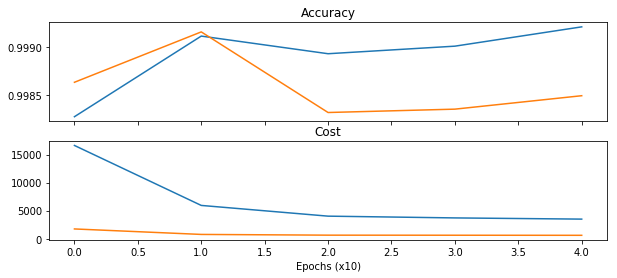

In [22]:
# In [35]
# Plot the accuracy and cost summaries
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary)          # blue
ax1.plot(valid_accuracy_summary)    # green
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()